# **PART 1**

The MNIST dataset was created in 1998 and represents digits written by high school students and employees of the United States Census Bureau. It  contains grayscale images of size 28×28. Each image corresponds to a hand-written digit between 0 and 9. It contains 60000 images on a training sample and 10000 images on a testing sample.

In this first part, we will implement a neural network that takes the image as output and returns a probability for each class.

## 1. Importing libraries

In [ ]:
!pip install -U keras-tuner

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt

from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from random import sample
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch

     |████████████████████████████████| 97 kB 3.2 MB/s 


Because the image size is 28×28, each observation contains the colour intensity of the 784 pixels. For example, the following figure shows all the 784 intensities of an image. We can thus observe the number 5 by assigning a colour conditioned to the intensity.



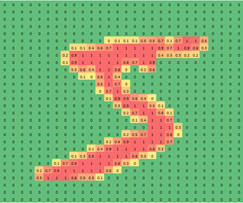

## 2. Import data



We normalize the pixels values by converting them to floats and by rescaling them between 0 and 1.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


In the next figure you can see some of these images:

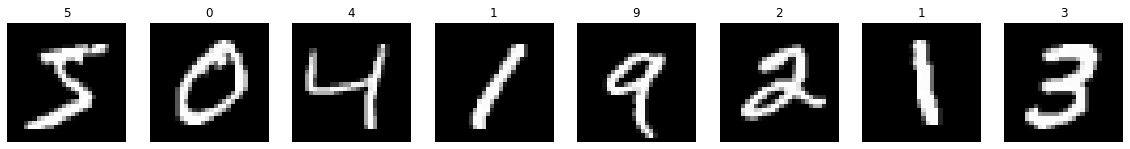

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(1, 9):
    img = x_train[i-1].reshape(28,28)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(y_train[i-1])
    plt.imshow(img, cmap = "gray")
plt.show()

We create some functions that will be useful later. The first function is inspired from [this website](https://www.tensorflow.org/tutorials/keras/classification/) while the second function is inspired from [this website](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/).

In [ ]:
def summarize_diagnostics(result, main):
    plt.title(main)
    plt.plot(result.history['accuracy'], color='blue', label='train')
    plt.plot(result.history['val_accuracy'], color='red', label='test')
    plt.legend(loc="upper left")
    plt.show()

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

## 3. Architecture A

The first neural network we are implementing is a fully connected neural network, meaning that each node from a given layer is connected to each node of the next layer. The input layer contains then 784 observations corresponding to each pixel. We choose two implement two layers : the first hosts 64 nodes with a “relu” activation function ; the second one hosts 128 nodes with a “relu” activation function. Finally, the output layer contains 10 nodes, allowing us to obtain the probability of each possible category (digits from 0 to 9). 

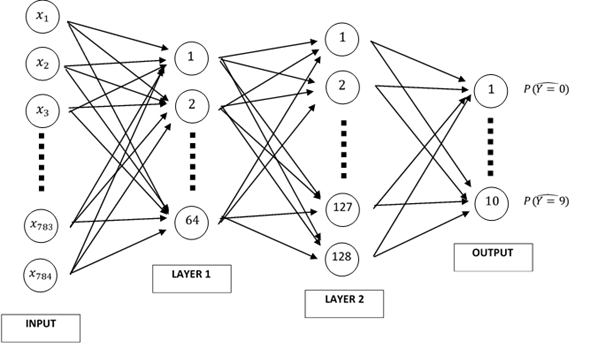

In [ ]:
modelA = keras.Sequential()
modelA.add(keras.Input(shape=(784,)))
modelA.add(layers.Dense(64, activation="relu"))
modelA.add(layers.Dense(128, activation="relu"))
modelA.add(layers.Dense(10, activation="softmax"))

In [ ]:
modelA.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 59,850
Trainable params: 59,850
Non-trainable params: 0
_________________________________________________________________


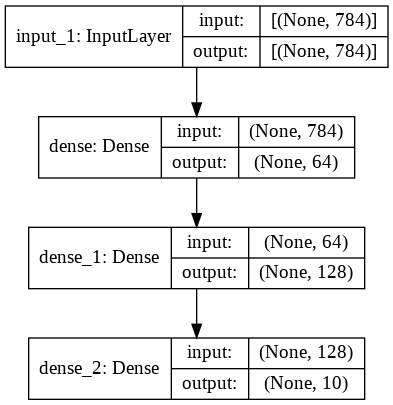

In [ ]:
keras.utils.plot_model(modelA, "modelA.png", show_shapes=True)

## 4. Architecture B

The model B is a convolutional neural network, meaning that a kernel is applied on each convolution scans window instead of applying a function to the entire image. The input layer contains the 784-pixel intensities reshaping into a 28×28 matrix. The first layer is then a convolutional layer with 32 nodes and a kernel size of size 3×3 corresponding to the size of the window. The second layer has the same properties as the first one. Then we had a pooling layer in order to deal with the problem of curse of high dimension followed by a flatten function to reshape the output obtained. Finally, the output layer contains 10 nodes to return the probability for each category.

In [ ]:
modelB = Sequential()
modelB.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
modelB.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
modelB.add(keras.layers.MaxPool2D(2,2))
modelB.add(Flatten())
modelB.add(Dense(10, activation="softmax"))

In [ ]:
modelB.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                46090     
Total params: 55,658
Trainable params: 55,658
Non-trainable params: 0
_________________________________________________________________


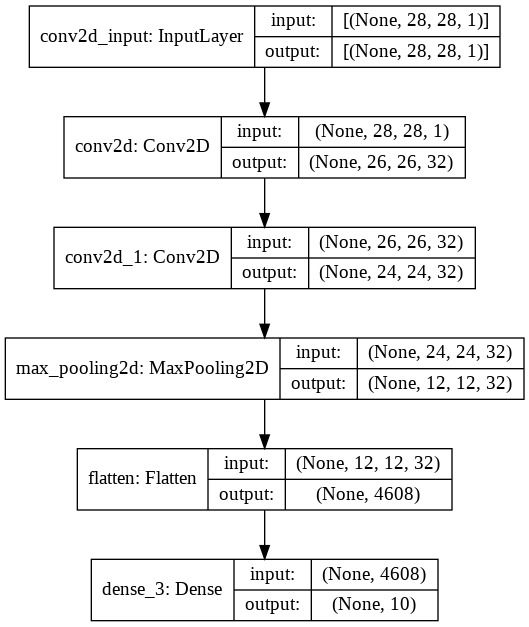

In [ ]:
keras.utils.plot_model(modelB, "modelB.png", show_shapes=True)

## 5. Training

By training our model on 50 000 images in the MNIST dataset and then testing each model on the test dataset, we obtain an accuracy of 97.1% for the architecture A and an accuracy of 98.6% for the architecture B. Then out convolutional model seems to work better on this dataset. We will then focus on the convolutional model and try to improve its performance by playing with the hyperparameters.

In [ ]:
modelA.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = keras.optimizers.RMSprop(),
    metrics = ["accuracy"],
)

historyA = modelA.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_split = 0.2)

test_scoresA = modelA.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scoresA[0])
print("Test accuracy:", test_scoresA[1])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


750/750 [==============================] - 6s 4ms/step - loss: 0.3406 - accuracy: 0.9025 - val_loss: 0.1816 - val_accuracy: 0.9458
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1617 - accuracy: 0.9511 - val_loss: 0.1436 - val_accuracy: 0.9576
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1147 - accuracy: 0.9650 - val_loss: 0.1162 - val_accuracy: 0.9645
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0888 - accuracy: 0.9726 - val_loss: 0.1182 - val_accuracy: 0.9669
Epoch 5/10
750/750 [==============================] - 3s 3ms/step - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.1149 - val_accuracy: 0.9666
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0612 - accuracy: 0.9812 - val_loss: 0.1052 - val_accuracy: 0.9718
Epoch 7/10
750/750 [==============================] - 3s 3ms/step - loss: 0.0542 - accuracy: 0.9836 - val_loss: 0.1053 - val_accuracy: 0.9698
Epoch 8/10
750/75

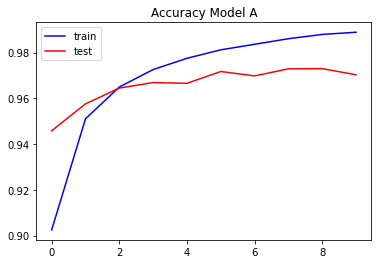

In [ ]:
summarize_diagnostics(historyA, "Accuracy Model A")

In [ ]:
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
y_train_categ = np_utils.to_categorical(y_train)
y_test_categ = np_utils.to_categorical(y_test)

In [ ]:
modelB.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


historyB = modelB.fit(x_train, y_train_categ, batch_size = 64, epochs = 10, validation_split = 0.2)

test_scoresB = modelB.evaluate(x_test, y_test_categ, verbose=2)
print("Test loss:", test_scoresB[0])
print("Test accuracy:", test_scoresB[1])

Epoch 1/10
750/750 [==============================] - 36s 9ms/step - loss: 0.2156 - accuracy: 0.9365 - val_loss: 0.0870 - val_accuracy: 0.9757
Epoch 2/10
750/750 [==============================] - 6s 9ms/step - loss: 0.0702 - accuracy: 0.9783 - val_loss: 0.0664 - val_accuracy: 0.9818
Epoch 3/10
750/750 [==============================] - 6s 9ms/step - loss: 0.0505 - accuracy: 0.9843 - val_loss: 0.0600 - val_accuracy: 0.9818
Epoch 4/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0395 - accuracy: 0.9874 - val_loss: 0.0630 - val_accuracy: 0.9811
Epoch 5/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0305 - accuracy: 0.9903 - val_loss: 0.0554 - val_accuracy: 0.9841
Epoch 6/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0253 - accuracy: 0.9915 - val_loss: 0.0592 - val_accuracy: 0.9841
Epoch 7/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0192 - accuracy: 0.9933 - val_loss: 0.0536 - val_accuracy: 0.9866
Epoch

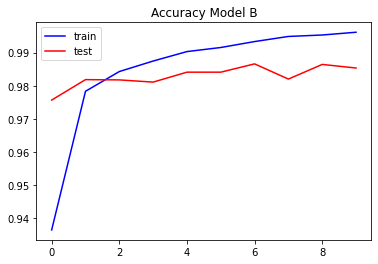

In [ ]:
summarize_diagnostics(historyB, "Accuracy Model B")

## 6. Improving our model

Using the optimization procedure offered by keras, we will try to optimize our hyperparameters in order to maximize the quality of our predictions. The hyperparameters we focus on are the number of nodes in the intermediate layers, we then make them varying according to the value {16,32,64} and we use the keras procedure to optimize these parameters. 

In [ ]:
def build_model(hp):
    
    modelB = Sequential()
    modelB.add(Conv2D(hp.Choice("layer_1_filters", [16,32,64]), kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
    modelB.add(Conv2D(hp.Choice("layer_2_filters", [16,32,64]), kernel_size=(3,3), activation="relu"))
    modelB.add(keras.layers.MaxPool2D(2,2))
    modelB.add(keras.layers.Dropout(0.5))
    modelB.add(Flatten())
    modelB.add(Dense(10, activation="softmax"))

    modelB.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

    return modelB

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
    directory='C:/Users/Antoi/OneDrive/Université/Master 2/Predictive Methods/MidTerm'
)

tuner.search(x_train, y_train, validation_split = 0.2, epochs=3, batch_size=32)

Trial 9 Complete [00h 00m 26s]
val_accuracy: 0.9815000295639038

Best val_accuracy So Far: 0.9871666431427002
Total elapsed time: 00h 06m 08s
INFO:tensorflow:Oracle triggered exit


The result of this optimization suggests that we implement 64 nodes on each intermediate layer. 

In [ ]:
tuner.results_summary()

Results summary
Results in C:/Users/Antoi/OneDrive/Université/Master 2/Predictive Methods/MidTerm/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer_1_filters: 64
layer_2_filters: 64
Score: 0.9871666431427002
Trial summary
Hyperparameters:
layer_1_filters: 32
layer_2_filters: 32
Score: 0.9855833053588867
Trial summary
Hyperparameters:
layer_1_filters: 16
layer_2_filters: 32
Score: 0.9853333234786987
Trial summary
Hyperparameters:
layer_1_filters: 32
layer_2_filters: 64
Score: 0.9851666688919067
Trial summary
Hyperparameters:
layer_1_filters: 16
layer_2_filters: 64
Score: 0.9851666688919067
Trial summary
Hyperparameters:
layer_1_filters: 64
layer_2_filters: 32
Score: 0.9849166870117188
Trial summary
Hyperparameters:
layer_1_filters: 64
layer_2_filters: 16
Score: 0.9834166765213013
Trial summary
Hyperparameters:
layer_1_filters: 32
layer_2_filters: 16
Score: 0.9821666479110718
Trial summary
Hyperparameters:
layer_1

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0360 - accuracy: 0.9874


[0.03598713502287865, 0.9873999953269958]

This new configuration allows to improve our prediction quality with an accuracy of about 98.7% on the testing set.

### Save and load a model

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [ ]:
best_model.save('./Modèle/model_ex1')

In [ ]:
loaded_model = keras.models.load_model('/content/gdrive/My Drive/Modèle/model_ex1')
loaded_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0360 - accuracy: 0.9874


[0.03598713502287865, 0.9873999953269958]

In [ ]:
loaded_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


historyB_improved = loaded_model.fit(x_train, y_train_categ, batch_size = 64, epochs = 10, validation_split = 0.2)

test_scoresB = loaded_model.evaluate(x_test, y_test_categ, verbose=2)
print("Test loss:", test_scoresB[0])
print("Test accuracy:", test_scoresB[1])

Epoch 1/10
750/750 [==============================] - 9s 11ms/step - loss: 0.0413 - accuracy: 0.9865 - val_loss: 0.0420 - val_accuracy: 0.9877
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0347 - accuracy: 0.9889 - val_loss: 0.0433 - val_accuracy: 0.9877
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0290 - accuracy: 0.9904 - val_loss: 0.0409 - val_accuracy: 0.9890
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0266 - accuracy: 0.9913 - val_loss: 0.0392 - val_accuracy: 0.9896
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0240 - accuracy: 0.9919 - val_loss: 0.0393 - val_accuracy: 0.9899
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.0393 - val_accuracy: 0.9892
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0419 - val_accuracy: 0.9893

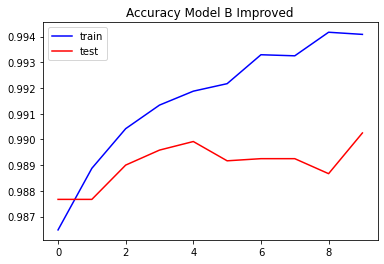

In [ ]:
summarize_diagnostics(historyB_improved, "Accuracy Model B Improved")

## 7. Visualize predictions

By following the recommandations of [here](https://www.tensorflow.org/tutorials/keras/classification), we create a function in order to visualize some predictions. We can see that the models succeed to find the good digit in these examples.

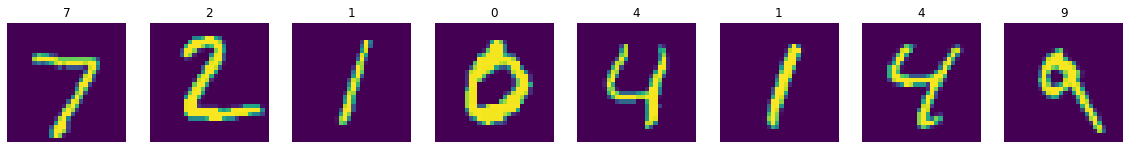

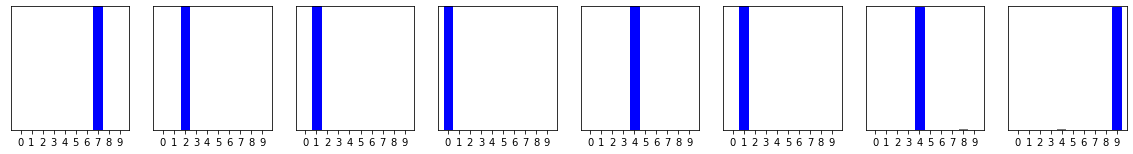

In [ ]:
predictions = loaded_model.predict(x_test)

fig = plt.figure(figsize=(20, 40))
for i in range(1, 9):
    img = x_test[i-1].reshape(28,28)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(y_test[i-1])
    plt.imshow(img, cmap = "gray")
plt.show()
fig = plt.figure(figsize=(20, 5))
for i in range(0, 8):
    fig.add_subplot(2, 8, i+1)
    plot_value_array(i, predictions[i],  y_test)
plt.show()

We may be interesting to know what are the images in which the models failed. Some of the bad predictions are represented in the next figure. We can see that even with our human brain, the digits are not so easy to find. Our neural network is then a good representation of the human brain.

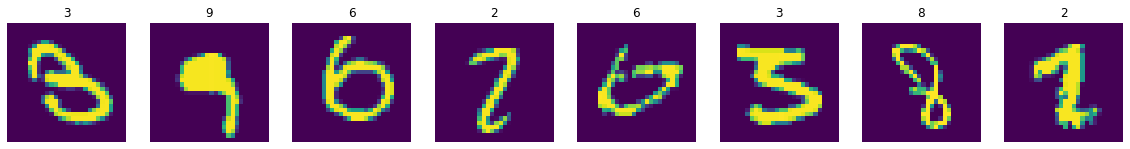

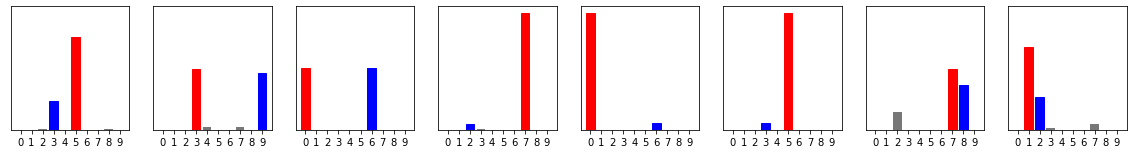

In [ ]:
bad_predictions = np.argmax(predictions, axis = (1)) != y_test

fig = plt.figure(figsize=(20, 40))
for i in range(1, 9):
    img = x_test[bad_predictions][i-1].reshape(28,28)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(y_test[bad_predictions][i-1])
    plt.imshow(img, cmap = "gray")
plt.show()
fig = plt.figure(figsize=(20, 5))
for i in range(0, 8):
    fig.add_subplot(2, 8, i+1)
    plot_value_array(i, predictions[bad_predictions][i],  y_test[bad_predictions])
plt.show()

## 8. Evaluate our model

As we have seen, we obtain an accuracy of 98.7% on the test sample. We can thus visualize the confusion matrix to observe the efficiency of our model according to the digit to be detected. 

In [ ]:
predictions = np.argmax(predictions, axis = (1))
predictions = predictions.reshape(10000,1)

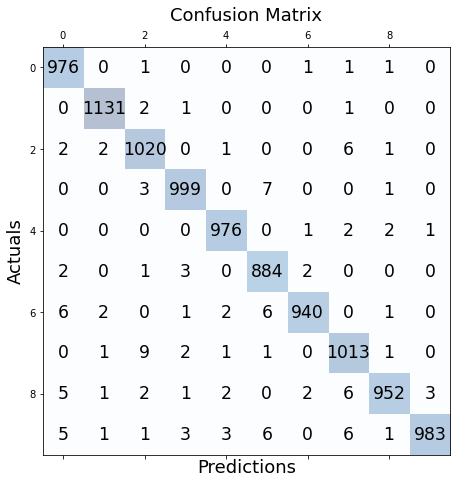

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# **Part 2**

## 1. Import data and create random images

In this second part, we will try to implement a model that distinguish between random images and an image where a digit is written. A random image contains pixels of random intensity between 0 and 1. The images with the digits are the one we used in the previous exercise. Therefore, our training dataset is composed of 60000 images, that is 30000 handwritten digits coming from the MNIST dataset and 30000 images randomly created. 

In [ ]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()

x_train_mnist = (np.delete(x_train_mnist, range(0, 30000), 0)
                 .reshape(30000, 28, 28, 1).astype("float32")/255)
x_test_mnist = (x_test_mnist
                .reshape(10000, 28, 28, 1).astype("float32")/255)
y_train_mnist = np.repeat(1, 30000)
y_test_mnist = np.repeat(1, 10000)

In [ ]:
x_train_random= np.random.uniform(0, 1, size=(30000, 28, 28, 1))
x_test_random = np.random.uniform(0, 1, size=(10000, 28, 28, 1))
y_train_random = np.repeat(0, 30000)
y_test_random = np.repeat(0, 10000)

In [ ]:
x_train = np.concatenate((x_train_mnist, x_train_random), axis=0)
y_train = np.concatenate((y_train_mnist, y_train_random), axis=0)
x_test = np.concatenate((x_test_mnist, x_test_random), axis=0)
y_test = np.concatenate((y_test_mnist, y_test_random), axis=0)

As illustrated in the next figure, our dependent variable takes the value 1 if the image corresponds to a handwritten digit and 0 otherwise.

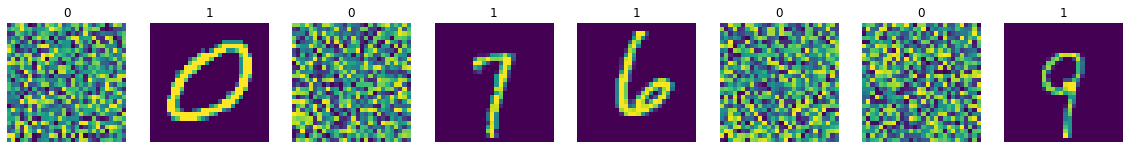

In [ ]:
fig = plt.figure(figsize=(20, 20))
loc = 0
for i in sample(range(0,60000), 8):
    loc = loc + 1
    img = x_train[i-1].reshape(28,28)
    fig.add_subplot(1, 8, loc)
    plt.axis("off")
    plt.title(y_train[i-1])
    plt.imshow(img, cmap = "gray")
plt.show()

## 2. Neural Network architecture

We start with a convolutional model with two intermediate layers. The first one contains 32 nodes, a kernel size of 3 by 3 and a “relu” activation function. The second one contains 64 nodes, a kernel size of 3 by 3 and a “relu” activation function. Finally, the ouput layer consists of 2 nodes because we have two possible category, the activation function being a “softmax”. 

In [ ]:
modelHW = Sequential()
modelHW.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(28,28, 1)))
modelHW.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
modelHW.add(Flatten())
modelHW.add(Dense(2, activation="softmax"))

In [ ]:
modelHW.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 73730     
Total params: 92,546
Trainable params: 92,546
Non-trainable params: 0
_________________________________________________________________


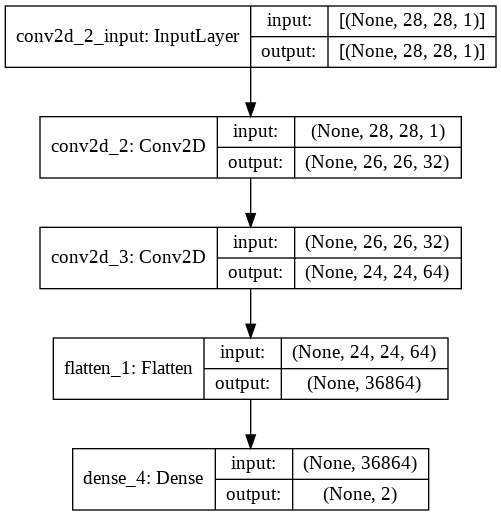

In [ ]:
keras.utils.plot_model(modelHW, "modelHW.png", show_shapes=True)

## 3. Training

By training our parameters on the training dataset and by testing the model on the test dataset, we quickly notice that this problem is a very easy one. Indeed, this non-complex model succeed to easily reach an accuracy of 1 both on the training set and on the testing set. Consequently, one could think that this model represents a bazooka, and the problem represents an insect and as the econometric proverb say : “it is useless to kill an insect with a bazooka”. Therefore, we decide to implement a less complex neural network, requiring estimating less parameters and thus allowing to kill the insect more quickly.

In [ ]:
y_train_categ = np_utils.to_categorical(y_train)
y_test_categ = np_utils.to_categorical(y_test)

In [ ]:
modelHW.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

historyHW = modelHW.fit(x_train, y_train_categ, validation_split = 0.2, batch_size = 64, epochs = 10)

test_scoresHW = modelHW.evaluate(x_test[0:10000,:,:], y_test_categ[0:10000,:], verbose=2)
print("Test loss on MNIST images:", test_scoresHW[0])
print("Test accuracy on MNIS images:", test_scoresHW[1])

test_scoresHW = modelHW.evaluate(x_test[10001:20000,:,:], y_test_categ[10001:20000,:], verbose=2)
print("Test loss on random images:", test_scoresHW[0])
print("Test accuracy on random images:", test_scoresHW[1])

Epoch 1/10
750/750 [==============================] - 9s 11ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 2.0821e-07 - val_accuracy: 1.0000
Epoch 2/10
750/750 [==============================] - 8s 10ms/step - loss: 1.4396e-07 - accuracy: 1.0000 - val_loss: 4.6909e-08 - val_accuracy: 1.0000
Epoch 3/10
750/750 [==============================] - 8s 10ms/step - loss: 9.4819e-08 - accuracy: 1.0000 - val_loss: 6.1611e-08 - val_accuracy: 1.0000
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 5.1310e-08 - accuracy: 1.0000 - val_loss: 2.3335e-08 - val_accuracy: 1.0000
Epoch 5/10
750/750 [==============================] - 8s 10ms/step - loss: 3.4502e-08 - accuracy: 1.0000 - val_loss: 1.5318e-08 - val_accuracy: 1.0000
Epoch 6/10
750/750 [==============================] - 8s 10ms/step - loss: 2.0289e-08 - accuracy: 1.0000 - val_loss: 1.1136e-08 - val_accuracy: 1.0000
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 1.2514e-08 - accuracy: 

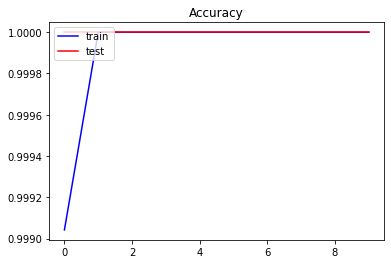

In [ ]:
summarize_diagnostics(historyHW, "Accuracy")

## 4. A less complex model

Then, the new architecture is the following : we make a pooling of size 2 by 2 on the data before going on the first intermediary layer. This is as if we consider the images of size 14 by 14 instead of 28 by 28. We also remove the second intermediary layer. By training and testing this new model, we obtain an accuracy of 1.

In [ ]:
modelHW = Sequential()
modelHW.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), input_shape=(28, 28, 1)))
modelHW.add(Conv2D(4, kernel_size=(2,2), activation="relu"))
modelHW.add(Flatten())
modelHW.add(Dense(2, activation="softmax"))

In [ ]:
modelHW.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 4)         20        
_________________________________________________________________
flatten_2 (Flatten)          (None, 676)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1354      
Total params: 1,374
Trainable params: 1,374
Non-trainable params: 0
_________________________________________________________________


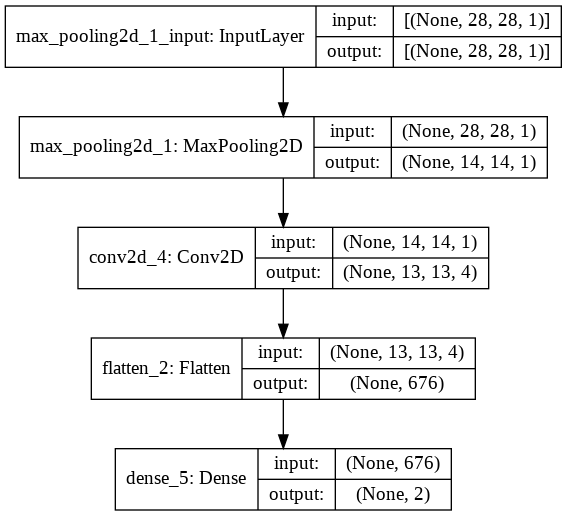

In [ ]:
keras.utils.plot_model(modelHW, "modelHW.png", show_shapes=True)

In [ ]:
modelHW.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

historyHW = modelHW.fit(x_train, y_train_categ, validation_split = 0.2, batch_size = 64, epochs = 2)

test_scoresHW = modelHW.evaluate(x_test[0:10000,:,:], y_test_categ[0:10000,:], verbose=2)
print("Test loss on MNIST images:", test_scoresHW[0])
print("Test accuracy on MNIS images:", test_scoresHW[1])

test_scoresHW = modelHW.evaluate(x_test[10001:20000,:,:], y_test_categ[10001:20000,:], verbose=2)
print("Test loss on random images:", test_scoresHW[0])
print("Test accuracy on random images:", test_scoresHW[1])

Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.0328 - accuracy: 0.9897 - val_loss: 4.0580e-04 - val_accuracy: 1.0000
Epoch 2/2
750/750 [==============================] - 3s 4ms/step - loss: 2.3040e-04 - accuracy: 1.0000 - val_loss: 1.0554e-04 - val_accuracy: 1.0000
313/313 - 1s - loss: 1.1385e-04 - accuracy: 1.0000
Test loss on MNIST images: 0.00011385182006051764
Test accuracy on MNIS images: 1.0
313/313 - 1s - loss: 1.0646e-04 - accuracy: 1.0000
Test loss on random images: 0.00010646343434927985
Test accuracy on random images: 1.0


Again, we reach the perfect classification very easily, meaning that we didn't need to implement a model as sophisticated as the first one.

# **Part 3**


## 1. Importing data

In this third part, we are going to apply a neural network on a more difficult dataset than those we were working so far. The CIFAR-10 dataset contains images of size 32 by 32. Each image describes an animal or an object including on this list:
*   Airplane
*   Auto
*   Bird
*   Cat
*   Deer
*   Dog
*   Frog
*   Horse
*   Ship
*   Truck



In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

170508288/170498071 [==============================] - 2s 0us/step


Contrary to the the MNIST dataset, the images are here in three dimensions where each dimension corresponding to a RGB color. 

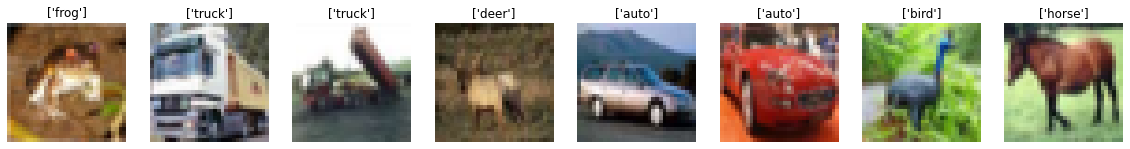

In [ ]:
xlabs = ('airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig = plt.figure(figsize=(20, 20))
for i in range(1, 9):
    img = x_train[i-1].reshape(32, 32, 3)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(np.array(xlabs)[y_train[i-1]])
    plt.imshow(img)
plt.show()

Contrary to the the MNIST dataset, the images are here in three dimensions where each dimension corresponding to a RGB color. The concatenation of each dimension permits to obtain a colored image:

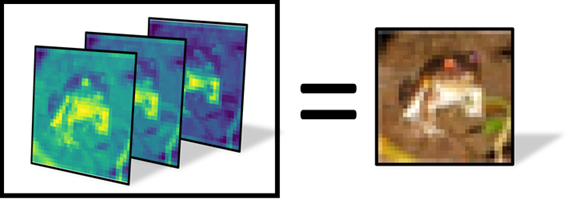

## 2. Descriptive statistics

There is not an infinite number of possibilities for making descriptive statistics on images. What we can look at is the distribution of categories within the database. As the following graph shows, the distribution of categories is perfectly balanced in the "train" dataset with 5000 images of each category.

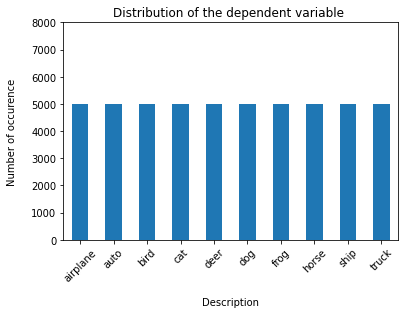

In [ ]:
pd.Series(y_train.reshape(50000,)).value_counts().plot(kind='bar')
plt.xticks(range(10), xlabs)
plt.xlabel("Description", labelpad=14)
plt.ylabel("Number of occurence", labelpad=14)
plt.ylim(0, 8000)
plt.xticks(rotation=45)
plt.title("Distribution of the dependent variable ")
plt.show()

Another statistic that we can observe is the variance of colour within categories. Indeed, one can think that the objects created by the human, like the trucks or the cars, have images with many different colours whereas images of animals can have similar colours on the whole image since the photo was probably took in the wild. For example, in the next figure the truck has a lot of different colours whereas the deer is in an environment with similar colours.

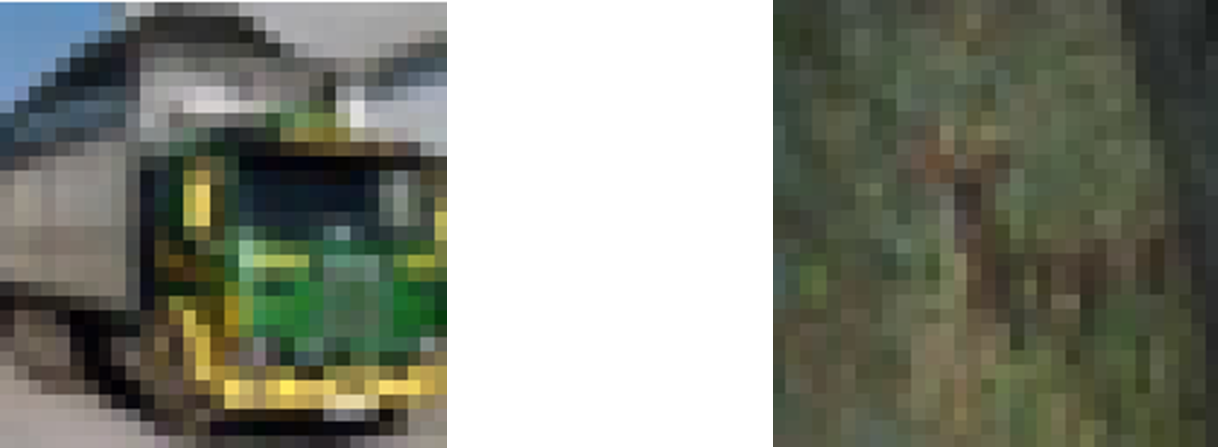

In [ ]:
color_variance = (pd
               .DataFrame(np
                          .concatenate((y_train.reshape(50000,1),
                                          np.var(x_train[:,:,:,:], axis = (1,2,3)).reshape(50000,1)), axis=1)))
color_variance = color_variance.rename(columns = {0 : "category", 1 : "Color_var"})

The next graph gives the variance of each pixel intensity for each category. As we were expected, the object created by the human as cars and trucks have a high variance whereas the animals have low colour variances. The airplane is the exception. One can think that airplane is an object with a single colour and the photos may have been taken often on a blue sky.

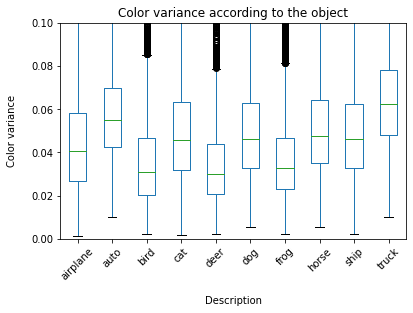

In [ ]:
color_variance.boxplot(column = "Color_var", by = 'category', grid=False)
plt.ylim(0, 0.1)
plt.xticks(range(1, 11), xlabs)
plt.xticks(rotation=45)
plt.xlabel("Description", labelpad=14)
plt.ylabel("Color variance", labelpad=14)
plt.title("Color variance according to the object")
plt.suptitle('')
plt.show()

## 3. Implement a neural network

We start with a basic convolutional neural network : 2 convolutional layers of respectively 32 and 10 nodes with a kernel size of 3 by 3.

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(32,32,3)))
model.add(Conv2D(10, kernel_size=(3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 10)        2890      
_________________________________________________________________
flatten (Flatten)            (None, 7840)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                78410     
Total params: 82,196
Trainable params: 82,196
Non-trainable params: 0
_________________________________________________________________


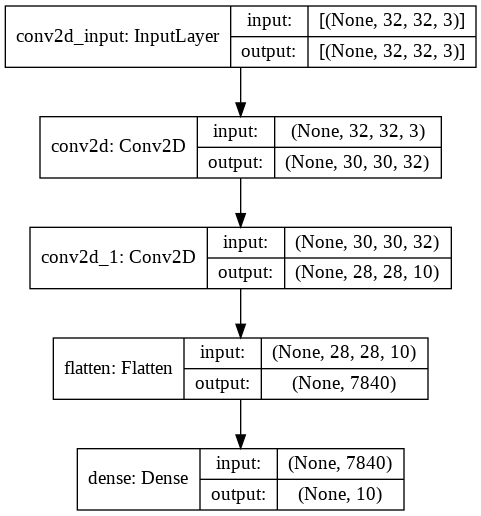

In [ ]:
keras.utils.plot_model(model, "modelHW.png", show_shapes=True)

### Training and testing

By training our model on 50000 observations and testing it on 10000 observations, we obtain an accuracy of 54.6% on the testing sample.


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

y_train_categ = np_utils.to_categorical(y_train)
y_test_categ = np_utils.to_categorical(y_test)

history_cifar = model.fit(x_train, y_train_categ, batch_size = 20, epochs = 10, validation_split = 0.2)

Epoch 1/10
2000/2000 [==============================] - 43s 6ms/step - loss: 1.5434 - accuracy: 0.4453 - val_loss: 1.3917 - val_accuracy: 0.5027
Epoch 2/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.2806 - accuracy: 0.5464 - val_loss: 1.3978 - val_accuracy: 0.5173
Epoch 3/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.1753 - accuracy: 0.5840 - val_loss: 1.2552 - val_accuracy: 0.5586
Epoch 4/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.1046 - accuracy: 0.6106 - val_loss: 1.2181 - val_accuracy: 0.5762
Epoch 5/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.0460 - accuracy: 0.6310 - val_loss: 1.2430 - val_accuracy: 0.5736
Epoch 6/10
2000/2000 [==============================] - 12s 6ms/step - loss: 0.9969 - accuracy: 0.6464 - val_loss: 1.2716 - val_accuracy: 0.5679
Epoch 7/10
2000/2000 [==============================] - 12s 6ms/step - loss: 0.9499 - accuracy: 0.6653 - val_loss: 1.2382 - val_ac

In [ ]:
test_scores_cifar = model.evaluate(x_test, y_test_categ, verbose=2)
print("Test loss:", test_scores_cifar[0])
print("Test accuracy:", test_scores_cifar[1])

313/313 - 1s - loss: 1.3857 - accuracy: 0.5465
Test loss: 1.3857451677322388
Test accuracy: 0.546500027179718


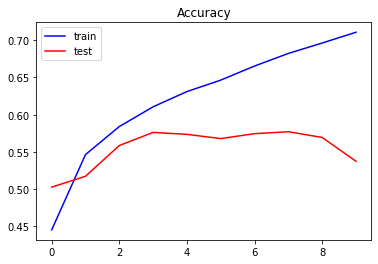

In [ ]:
summarize_diagnostics(history_cifar, "Accuracy")

### Visualization

By visualizing the results, we observe that our neural network is making some mistakes that our human brain would not have made. We therefore believe that it is possible to obtain better results by making our neural network more complex. 

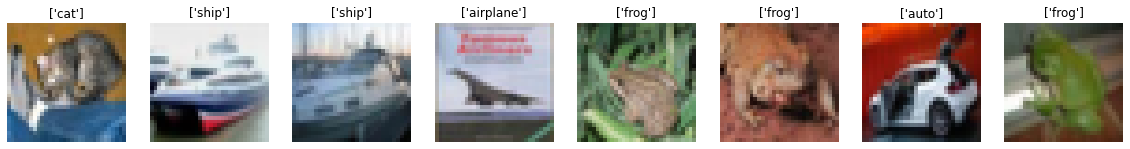

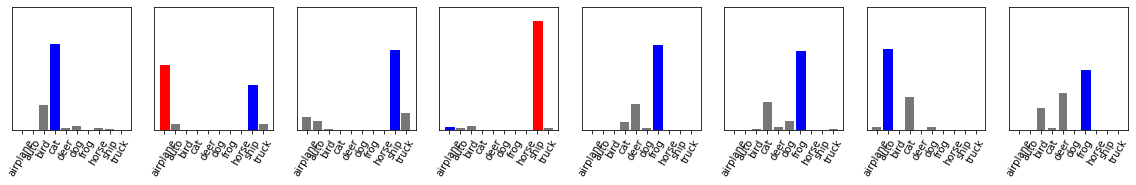

In [ ]:
proba = model.predict(x_test)

fig = plt.figure(figsize=(20, 40))
for i in range(1, 9):
    img = x_test[i-1].reshape(32, 32, 3)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(np.array(xlabs)[y_test[i - 1 ]])
    plt.imshow(img)
plt.show()
fig = plt.figure(figsize=(20, 5))
for i in range(0, 8):
    fig.add_subplot(2, 8, i+1)
    plot_value_array(i, proba[i],  y_test.reshape(10000,))
    plt.xticks(range(10), xlabs)
    plt.xticks(rotation=60)
plt.show()

### Evaluation

Here is the confusion matrix which allows us to observe on which categories the algorithm is most wrong. We thus calculate that the model is only wrong in 32% of cases when it predicts "truck" while it is wrong in 58% of cases when it predicts "cat" .

In [ ]:
predictions = np.argmax(proba, axis = (1))
predictions = predictions.reshape(10000,1)

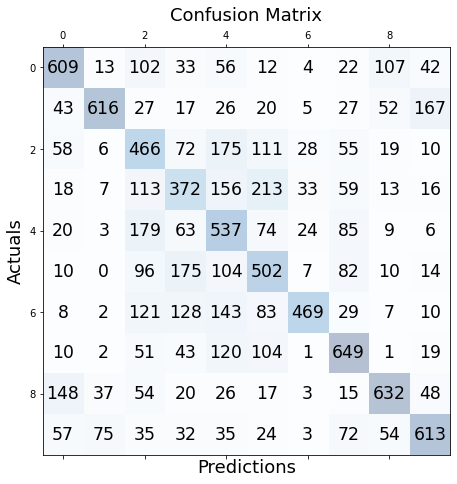

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## 4. Improving our model

In [ ]:
y_train_categ = np_utils.to_categorical(y_train)
y_test_categ = np_utils.to_categorical(y_test)

### Add more convolutional layer

Using the KERAS hyperparameter optimization procedure, we start by trying to find an optimal number of layers to put in place in the neural network. Thus, we vary the number of times we add 2 layers and one pooling. Padding are used on each convolutionnal layer in order to make sure that the size of the inputs can be received by the layers. I also choose to choose a normal distribution for the kernel initializer, which represents the distribution to use for initialising the weights, because I found it better than the default parameter. 

We also add a layer just before the output layer of which we vary the number of nodes. 

In [ ]:
def build_model(hp):


    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
      model.add(Conv2D(64+32*i, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))  
      model.add(Conv2D(64+32*i, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))
      model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Choice("Dense layer", [64, 128]), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
  
    model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32
    )

tuner.search(x_train, y_train_categ, validation_split = 0.2, epochs=10, batch_size=64)

Trial 7 Complete [00h 01m 23s]
val_accuracy: 0.6780999898910522

Best val_accuracy So Far: 0.7760000228881836
Total elapsed time: 00h 12m 14s
INFO:tensorflow:Oracle triggered exit


This optimization suggests that we implement 4 (because the loop started at 0) convolutional double-layers as well as 128 nodes in the layer before that of the output. 

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Conv Layers: 2
Dense layer: 128
Score: 0.7760000228881836
Trial summary
Hyperparameters:
Conv Layers: 2
Dense layer: 64
Score: 0.7638999819755554
Trial summary
Hyperparameters:
Conv Layers: 3
Dense layer: 128
Score: 0.7558000087738037
Trial summary
Hyperparameters:
Conv Layers: 1
Dense layer: 128
Score: 0.7524999976158142
Trial summary
Hyperparameters:
Conv Layers: 1
Dense layer: 64
Score: 0.7391999959945679
Trial summary
Hyperparameters:
Conv Layers: 0
Dense layer: 128
Score: 0.6780999898910522
Trial summary
Hyperparameters:
Conv Layers: 0
Dense layer: 64
Score: 0.6685000061988831


The new configurations allow us to increase the accuracy from 54.7% to 76.5% on the test sample.

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.evaluate(x_test, y_test_categ)

313/313 [==============================] - 3s 7ms/step - loss: 0.7170 - accuracy: 0.7655


[0.7169667482376099, 0.765500009059906]

In [ ]:
best_model.save('./Modèle/model_ex3_V2')

INFO:tensorflow:Assets written to: ./Modèle/model_ex3_V2/assets


In [ ]:
loaded_model = keras.models.load_model('/content/gdrive/My Drive/Modèle/model_ex3_V2')
loaded_model.evaluate(x_test, y_test_categ)

313/313 [==============================] - 2s 7ms/step - loss: 0.7170 - accuracy: 0.7655


[0.7169667482376099, 0.765500009059906]

### Add a drop out

Now, I will try to implement dropout layers in the neural network. This technique is used to randomly drop nodes out of the neural network with a regularizing effect.

In [ ]:
def build_model(hp):

    val1 = hp.Choice("val drop1", [0.0, 0.1, 0.2])
    val2 = hp.Choice("val drop2", [0.0, 0.05, 0.1])

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(val1))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))  
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(val1 + val2))
    model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(val1 + 2*val2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))  
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='normal', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(val1 + 3*val2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout( hp.Choice("val drop3", [0.0, 0.1, 0.2])))
    model.add(Dense(10, activation='softmax'))
  
    model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32
    )

tuner.search(x_train, y_trai  n_categ, validation_split = 0.2, epochs=10, batch_size=64)

Trial 25 Complete [00h 02m 24s]
val_accuracy: 0.760699987411499

Best val_accuracy So Far: 0.7760999798774719
Total elapsed time: 00h 56m 55s
INFO:tensorflow:Oracle triggered exit


The optimization suggests to implement a dropout of 10% for all the first-four dropout layers and 20% for the last dropout layer.

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
val drop1: 0.1
val drop2: 0.0
val drop3: 0.2
Score: 0.7760999798774719
Trial summary
Hyperparameters:
val drop1: 0.1
val drop2: 0.05
val drop3: 0.1
Score: 0.7746000289916992
Trial summary
Hyperparameters:
val drop1: 0.0
val drop2: 0.05
val drop3: 0.1
Score: 0.7703999876976013
Trial summary
Hyperparameters:
val drop1: 0.0
val drop2: 0.05
val drop3: 0.0
Score: 0.7671999931335449
Trial summary
Hyperparameters:
val drop1: 0.1
val drop2: 0.0
val drop3: 0.0
Score: 0.7671999931335449
Trial summary
Hyperparameters:
val drop1: 0.1
val drop2: 0.05
val drop3: 0.2
Score: 0.7663000226020813
Trial summary
Hyperparameters:
val drop1: 0.2
val drop2: 0.0
val drop3: 0.2
Score: 0.765999972820282
Trial summary
Hyperparameters:
val drop1: 0.0
val drop2: 0.1
val drop3: 0.0
Score: 0.7659000158309937
Trial summary
Hyperparameters:
val drop1: 0.2
val drop2: 0.0
val

This configuration allows us to reach an accuracy of 76.8%.

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.evaluate(x_test, y_test_categ)

313/313 [==============================] - 3s 8ms/step - loss: 0.6929 - accuracy: 0.7675


[0.6928918361663818, 0.7674999833106995]

In [ ]:
best_model.save('./Modèle/model_ex3_V3')

INFO:tensorflow:Assets written to: ./Modèle/model_ex3_V3/assets


In [ ]:
loaded_model = keras.models.load_model('/content/gdrive/My Drive/Modèle/model_ex3_V3')
loaded_model.evaluate(x_test, y_test_categ)

313/313 [==============================] - 3s 8ms/step - loss: 0.6929 - accuracy: 0.7675


[0.6928918361663818, 0.7674999833106995]

We can see that the bad predictions that were made with the previous model are not made with this new model. 

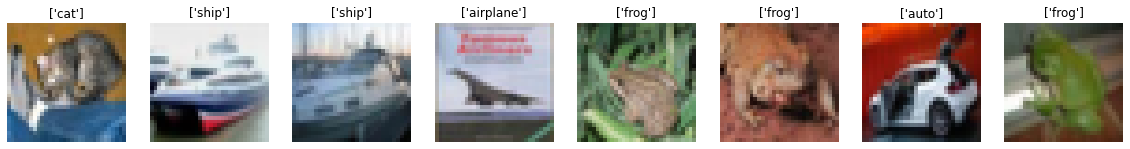

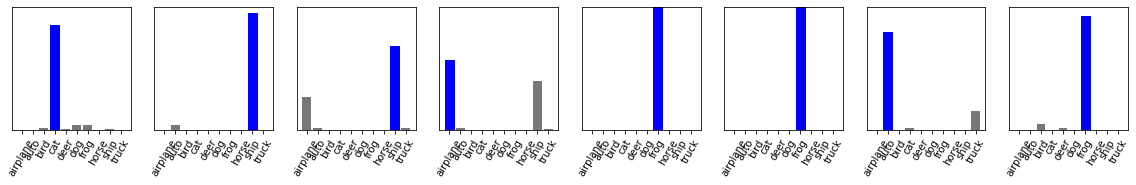

In [ ]:
proba = best_model.predict(x_test)

fig = plt.figure(figsize=(20, 40))
for i in range(1, 9):
    img = x_test[i-1].reshape(32, 32, 3)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(np.array(xlabs)[y_test[i - 1 ]])
    plt.imshow(img)
plt.show()
fig = plt.figure(figsize=(20, 5))
for i in range(0, 8):
    fig.add_subplot(2, 8, i+1)
    plot_value_array(i, proba[i],  y_test.reshape(10000,))
    plt.xticks(range(10), xlabs)
    plt.xticks(rotation=60)
plt.show()

We can focus on the bad predictions and observe that the images on which the algorithm is wrong are probably images which are not very representative of the overall sample with different points of view, more or less zoomed in images. 

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


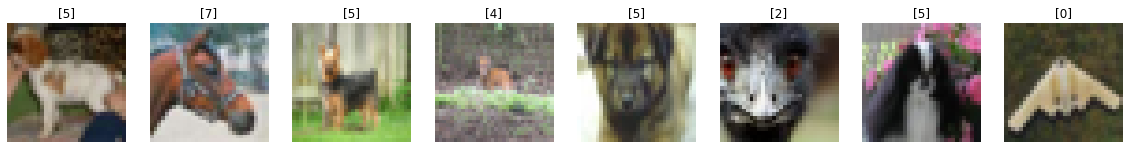

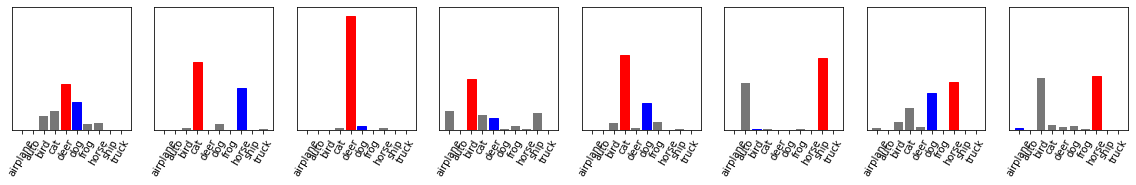

In [ ]:
bad_predictions = np.argmax(proba, axis = (1)) != y_test.reshape(10000,)

fig = plt.figure(figsize=(20, 40))
for i in range(1, 9):
    img = x_test[bad_predictions][i-1].reshape(32, 32, 3)
    fig.add_subplot(1, 8, i)
    plt.axis("off")
    plt.title(y_test[bad_predictions][i-1])
    plt.imshow(img)
plt.show()
fig = plt.figure(figsize=(20, 5))
for i in range(0, 8):
    fig.add_subplot(2, 8, i+1)
    plot_value_array(i, proba[bad_predictions][i],  true_label = y_test.reshape(10000,)[bad_predictions])
    plt.xticks(range(10), xlabs)
    plt.xticks(rotation=60)
plt.show()

The confusion matrix can also be useful to study which categories our algorithm "confuses" the most. In the following figure, we can see that our algorithm confuses category 3 (cat) and category 5 (dog) in 305 cases (160 + 145) while it confuses category 1 (airplane) and category 5 (dog) in only 3 cases (0 + 3). Then we can think that an image classifier can also be an objective indicator to determine the degree of similarity between different elements such as animals or objects.

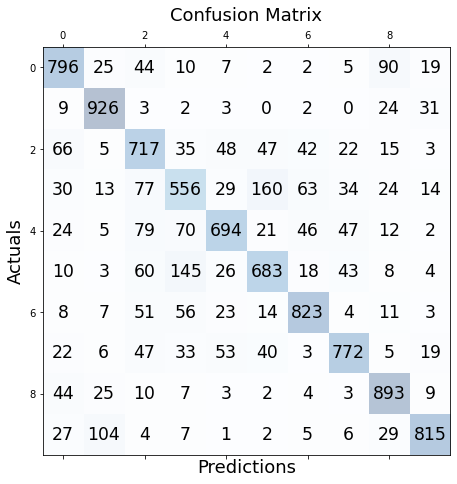

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=np.argmax(proba, axis = (1)).reshape(10000,1))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()